# 6장 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

In [2]:
from IPython.display import Image
%matplotlib inline

## 파이프라인을 사용한 효율적인 워크플로

새로운 데이터의 스케일을 조정하고 압축하기 위해 학습한 파라미터 재사용 해야함

사이킷 런의 Pipeline 클래스를 사용하면 여러 개의 변환 단계를 포함한 모델을 학습하고 새로운 데이터에 대한 예측을 만들 수 있음

### 위스콘신 유방암 데이터셋

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# UCI 머신 러닝 저장소에서 유방암 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df = pd.read_csv('wdbc.data', header=None)

#32개의 컬럼...
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# 원본 문자열표현 정수 변환
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
# 매핑확인
le.transform(['M', 'B'])

array([1, 0])

In [6]:
# 훈련(80%), 테스트(20%) 데이터셋 나눔
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

### 파이프라인으로 변환기와 추정기 연결

In [7]:
'''
주성분 분석(PCA)으로 30여개의 차원을 2차원 부분 공간으로 데이터 압축
훈련 데이터셋과 테스트 데이터셋을 각각 학습하고 변환하는 단계를 구성하는 대신 StandardScaler, PCA, LogisticRegression 객체를 하나의 파이프라인으로 연결

Pipeline 객체의 fit 메서드를 호출하면 데이터가 중간 단계에 있는 모든 변환기의 fit 메서드와 transform 메서드를 차례로 거쳐 추정기 객체(파이프라인의 마지막 단계)에 도달. 추정기는 변환된 훈련 데이터셋을 사용하여 학습
1. pipe_lr 파이프라인의 fit 메서드를 호출할 때 먼저 훈련 데이터셋에 StandardScaler 의 fit 메서드와 transform 메서드가 호출(StandardScaler())
2. 변환된 훈련 데이터는 파이프라인의 다음 요소인 PCA 객체로 전달, 이전 단계와 비슷하게 스케일 조정된 입력 데이터에 PCA의 fit 메서드와 transform 메서드가 호출 (PCA(n_components=2))
3. 파이프라인의 최종 요소인 추정기에 훈련 데이터가 전달(LogisticRegression)
'''
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'테스트 정확도: {test_acc:.3f}')

테스트 정확도: 0.956


In [8]:
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

In [9]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_01.png', width=500)

## k-폴드 교차검증을 사용한 모델 성능평가(k-겹 교차검증)

보편적인 교차 검증 기법인 홀드아웃 방법(holdout method)과 k-겹 교차 검증(k-fold cross-validation)을 학습

### 홀드아웃 방법

In [10]:
'''
홀드 아웃 방법은 초기 데이터셋을 별도의 훈련 데이터셋과 테스트 데이터셋으로 나눔
일반적인 머신 러닝 애플리케이션에서는 처음 본 데이터에서 예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교 하는 것을 '모델 선택'
모델 선택은 주어진 분류 문제에서 튜닝할 파라미터(또는 하이퍼파라미터)의 최적 값을 선택해야 하는 것을 의미
모델 선택에 같은 테스트 데이터셋을 반복해서 재사용하면 훈련 데이터셋의 일부가 되는 셈이고 결국 모델은 과대적합 됨
모델 선택에 홀드아웃 방법을 사용하는 가장 좋은 방법은 데이터를 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋 세 개의 부분으로 나눔
훈련 데이터셋은 여러 가지 모델을 훈련하는 데 사용. 검증 데이터셋에 대한 성능은 모델 선택에 사용. 테스트 데이터셋을 분리했기 때문에 새로운 데이터에 대한 일반화 능력을 덜 편향되게 추정할 수 있는 장점
만족할 만한 하이퍼파라미터 값을 얻었다면 테스트 데이터셋에서 모델의 일반화 성능을 추정
'''
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_02.png', width=500)

### k폴드 교차 검증

In [11]:
'''
k-폴드 교차 검증에서는 중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드(fold)로 랜덤하게 나눔.
k-1개의 폴드(이를 훈련 폴드(training fold)라고 함)로 모델을 훈련하고 나머지 하나의 폴드(이를 테스트 폴드(test fold)라고 함)로 성능을 평가
이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻음
서로 다른 독립적인 폴드에서 얻은 성능 추정을 기반으로 모델의 평균 성능을 계산. 일반적으로 모델 튜닝에 k-겹 교차 검증을 사용
즉, 테스트 데이터셋에서 모델의 성능을 평가할 때 만족할 만한 일반화 성능을 내는 최적의 하이퍼파라미터 값을 찾기 위해 사용
하이퍼파라미터를 찾은 후, 전체 훈련 데이터셋을 사용하여 모델을 다시 훈련. 독립적인 테스트 데이터셋을 사용하여 최종 성능 추정
k폴드 교차검증 후 전체 훈련 데이터셋으로 학습하는 이유는 하나의 최종 모델이 필요하고, 학습 알고리즘이 더 정확하고 안정적인 모델을 만듦
k폴드 교차 검증에서 모든 데이터 포인트가 평가에 사용되기 때문에 검증 세트를 사용하는 홀드아웃 방법보다 k폴드 교차 검증이 데이터셋을 더 잘 활용
'''
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_03.png', width=500)

In [12]:
'''
k폴드 교차 검증에서 좋은 기본값은 k = 10
론 코하비(Ron Kohavi)는 여러 종류의 실제 데이터셋에서 수행한 실험을 통해 10-겹 교차 검증이 가장 뛰어난 편향 -분산 트레이드오프를 가진다고 제안
작은 훈련 데이터셋에는 k값을 늘려서 훈련 데이터가 각 반복에 사용되어 일반화 성능을 추정할 때 낮은 편향을 만듦
큰 훈련 데이터셋에는 k값을 줄여서 모델의 평균 성능을 정확하게 추정하고, 폴드마다 학습하고 평가하는 계산 비용을 줄임
'''
import numpy as np
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)

    print(f'폴드: {k+1:02d}, '
          f'클래스 분포: {np.bincount(y_train[train])}, '
          f'정확도: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV 정확도: {mean_acc:.3f} +/- {std_acc:.3f}')

폴드: 01, 클래스 분포: [256 153], 정확도: 0.935
폴드: 02, 클래스 분포: [256 153], 정확도: 0.935
폴드: 03, 클래스 분포: [256 153], 정확도: 0.957
폴드: 04, 클래스 분포: [256 153], 정확도: 0.957
폴드: 05, 클래스 분포: [256 153], 정확도: 0.935
폴드: 06, 클래스 분포: [257 153], 정확도: 0.956
폴드: 07, 클래스 분포: [257 153], 정확도: 0.978
폴드: 08, 클래스 분포: [257 153], 정확도: 0.933
폴드: 09, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


In [13]:
# k-폴드 교차 검증 모델 평가
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f'CV 정확도 점수: {scores}')
print(f'CV 정확도: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


In [14]:
'''
cross_validate 함수는 각 폴드에서 훈련과 테스트에 걸린 시간을 반환하고 scoring 매개변수에 지정한 평가 지표마다 훈련 점수와 테스트 점수를 반환
'''
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        scoring=['accuracy'],
                        cv=10,
                        n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


In [15]:
'''
cross_val_predict 함수는 cross_val_score와 비슷한 인터페이스를 제공하지만 훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때 만들어진 예측을 반환
훈련 데이터셋에 대한 예측 결과를 시각화하거나 다른 모델에 주입할 훈련 데이터를 만들기 위해 사용
'''
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          n_jobs=-1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [16]:
'''
method 매개변수에 반환될 값을 계산하기 위한 모델의 메서드를 지정
method='predict_ proba'로 지정하면 예측 확률을 반환, 기본값은 'predict'
'''
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          method='predict_proba',
                          n_jobs=-1)
preds[:10]

array([[9.94012059e-01, 5.98794102e-03],
       [7.64607902e-01, 2.35392098e-01],
       [9.72784305e-01, 2.72156951e-02],
       [8.41865784e-01, 1.58134216e-01],
       [9.97161118e-01, 2.83888175e-03],
       [9.99805436e-01, 1.94563743e-04],
       [9.99329649e-01, 6.70351232e-04],
       [2.09400816e-06, 9.99997906e-01],
       [1.28535609e-01, 8.71464391e-01],
       [7.71820369e-04, 9.99228180e-01]])

## 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

학습 알고리즘의 성능 향상에 도움이 되는 간단하지만 아주 강력한 두 개의 분석 도구 학습 곡선과 검증 곡선

### 학습 곡선으로 편향과 분산 문제 분석

In [17]:
'''
왼쪽 위 그래프는 편향이 높은 모델 - 훈련 데이터에 과소적합, 일반적인 해결방법은 모델의 파라미터 개수를 늘림(추가적인 특성을 수집, 규제강도를 줄임)
오른쪽 위 그래프는 분산이 높은 모델 - 훈련 정확도와 교차 검증 정확도 사이에 큰 차이 과대적합, 더 많은 훈련 데이터를 모으거나 모델 복잡도를 낮추거나 규제를 증가(특성 선택, 특성 추출)
오른쪽 아래 그래프는 분산-편향이 좋은 모델

주황색 점선 - 훈련 정확도
파란색 실선 - 검증 정확도
검정색 점선 - 기대 정확도
'''
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_04.png', width=600)

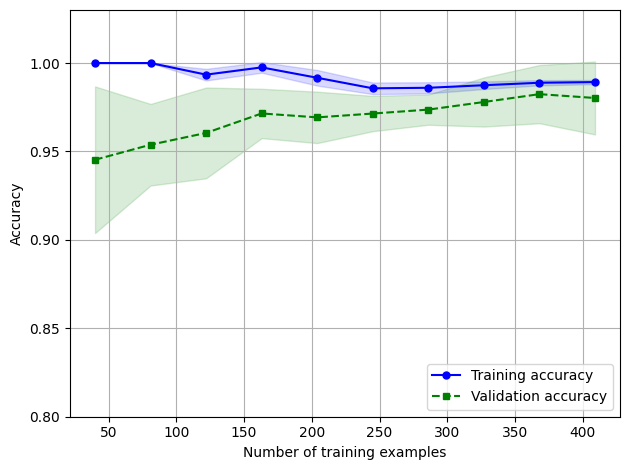

In [18]:
# 사이킷런의 학습 곡선 함수를 사용하여 모델을 평가
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

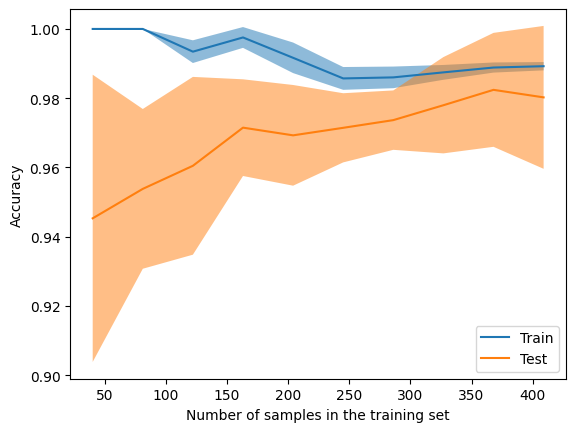

In [19]:
'''
learning_curve 함수의 반환값을 사용하여 학습 곡선을 손쉽게 그려 주는 LearningCurve Display 클래스
'''
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay(train_sizes=train_sizes,
                               train_scores=train_scores,
                               test_scores=test_scores,
                               score_name="Accuracy")
display.plot(score_type='both')
plt.legend(loc='lower right')
plt.show()

### 검증 곡선으로 과대적합과 과소적합 조사

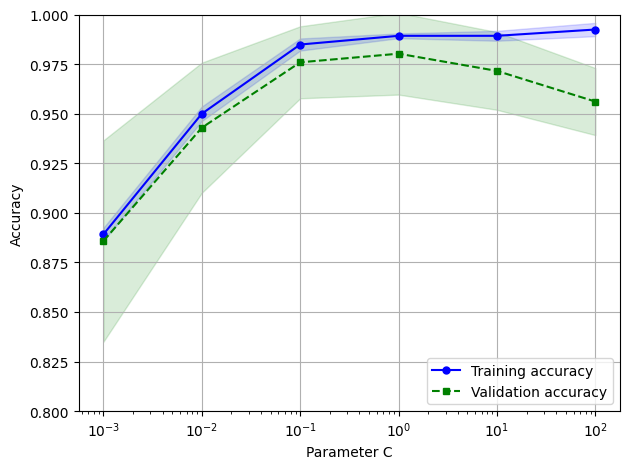

In [20]:
'''
검증 곡선은 과대적합과 과소적합 문제를 해결하여 모델 성능을 높일 수 있는 유용한 도구
C 매개변수에 대한 검증 곡선 그래프
'''
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='logisticregression__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('figures/06_06.png', dpi=300)
plt.show()

## 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

머신 러닝에는 두 종류의 파라미터가 있습니다. 하나는 훈련 데이터에서 학습되는 파라미터(로지스틱 회귀의 가중치)

다른 하나는 별도로 최적화되는 학습 알고리즘의 파라미터, 모델의 튜닝 파라미터, 하이퍼파라미터라고 부름(로지스틱 회귀의 규제 매개변수나 결정 트리의 최대 깊이 매개변수)

그리드서치는 하이퍼파라미터 최적화 기법으로 하이퍼파라미터 값에 대한 최적의 조합을 찾음으로써 모델 성능을 향상

### 그리드 서치를 사용한 하이퍼파라미터 튜닝

In [21]:
'''
리스트로 지정된 여러 가지 하이퍼파라미터 값 전체를 모두 조사, 이 리스트에 있는 값의 모든 조합에 대해 모델 성능을 평가하여 최적의 조합을 찾음
'''
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  refit=True,
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [22]:
# 독립적인 테스트 데이터셋을 사용하여 최고 모델의 성능을 추정
clf = gs.best_estimator_

# refit=True로 지정했기 때문에 다시 fit() 메서드를 호출할 필요가 없습니다. 전체 훈련 데이터셋에서 자동으로 gs.best_estimator_를 다시 훈련
# clf.fit(X_train, y_train)

print(f'테스트 정확도: {clf.score(X_test, y_test):.3f}')

테스트 정확도: 0.974


In [23]:
'''
cross_validate 함수에서 return_train_score 매개변수를 True로 지정하면 훈련 폴드에 대한 점수를 계산하여 반환
첫 번째 폴드의 점수는 'split0_train_score' 키
'''
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  return_train_score=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [24]:
'''
전체 훈련 점수의 평균값은 'mean_train_score' 키
'''

gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [25]:
'''
첫 번째 폴드에 대한 테스트 점수는 'split0_test_score' 키
'''
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

In [26]:
'''
최종 모델의 score메서드(predict, transform 등)
'''
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.974


### 랜덤 서치로 하이퍼파라미터 설정을 더 넓게 탐색하기

그리드 서치는 완전 탐색으로 사용자가 지정한 파라미터 그리드(parameter grid)에 최적의 하이퍼파라미터가 포함되어 있다면 반드시 찾을 수 있음.

하이퍼파라미터 그리드 설정이 크면 그리드 서치 비용이 많이 소요.

여러 파라미터 조합을 샘플링하는 또 다른 방식은 랜덤 서치(randomized search).

랜덤 서치에서는 분포(또는 이산적인 집합)에서 랜덤하게 하이퍼파라미터 설정을 샘플링.

랜덤 서치는 하이퍼파라미터 공간에 대해 완전 탐색을 수행하지 않음. 비용과 시간 측면에서 더 효율적으로 넓은 범위의 하이퍼파라미터 값을 탐색

In [27]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_11.png', width=600)

In [28]:
'''
이산적인 값 리스트를 샘플링 분포로 대체 하는것이 랜덤서치의 주요 이점
'''
import scipy.stats


param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]
# 로그 균등 분포로 [0.0001, 0.001] 범위에서 [10.0, 100.0]과 동일한 개수의 샘플 추출
param_range = scipy.stats.loguniform(0.0001, 1000.0)

# rvs(10) 메서드로 열 개의 샘플 추출
np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [29]:
# RandomizedSearchCV를 사용해서 SVM 튜닝
from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

### SH 방식을 사용한 자원 효율적인 하이퍼파라미터 탐색

사이킷런은 적절한 하이퍼파라미터 설정을 보다 효율적으로 찾는 SH(Successive Halving) 방식의 일종인 HalvingRandomSearchCV를 제공

SH 방식은 후보 설정 집합에서 하나의 설정이 남을 때까지 적합하지 않은 하이퍼파라미터 설정을 연속적으로 버림

1. 랜덤 샘플링을 통해 후보 설정의 집합을 샘플링

2. 제한된 자원, 예를 들어 (전체 훈련 세트가 아니라) 훈련 데이터의 일부로 모델을 훈련

3. 예측 성능을 기준으로 하위 50%를 버림

4. 가용한 자원을 늘려 단계 2로 돌아감

하나의 하이퍼파라미터 설정이 남을 때까지 이 단계가 반복

In [30]:
# 그리드 서치를 위한 SH 방식인 HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

hs = HalvingRandomSearchCV(
    pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples',
    factor=1.5,
    random_state=1,
    n_jobs=-1)

In [31]:
hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)

0.9617647058823529
{'svc__C': np.float64(4.934834261073333), 'svc__kernel': 'linear'}


In [32]:
clf = hs.best_estimator_
print(f'테스트 정확도: {hs.score(X_test, y_test):.3f}')

테스트 정확도: 0.982


### 중첩 교차 검증을 사용한 알고리즘 선택

그리드 서치나 랜덤 서치와 k-겹 교차 검증을 함께 사용하면 머신 러닝 모델의 성능을 세부 튜닝하기 좋음.

여러 종류의 머신 러닝 알고리즘을 비교하려면 중첩 교차 검증(nested cross-validation) 방법이 권장.

중첩된 교차 검증을 사용했을 때 테스트 데이터셋에 대한 추정 오차는 거의 편향되지 않음.


In [33]:
'''
중첩 교차 검증은 바깥쪽 k-겹 교차 검증 루프가 데이터를 훈련 폴드와 테스트 폴드로 나누고, 안쪽 루프가 훈련 폴드에서 k-겹 교차 검증을 수행하여 모델을 선택

모델이 선택되면 테스트 폴드를 사용하여 모델 성능을 평가

아래 그림은 바깥 루프에 다섯 개의 폴드를 사용하고 안쪽 루프에 두 개의 폴드를 사용하는 중첩 교차 검증의 개념

이러한 방식은 계산 성능이 중요한 대용량 데이터셋에서 유용

중첩 교차 검증의 폴드 개수를 고려하여 n×m 교차 검증이라고 함 (5개의 폴드와 2개의 폴드 5x2 교차 검증)

'''
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_07.png', width=500)

In [34]:
'''
그리드 서치를 사용한 중첩 교차 검증
반환된 평균 교차 검증 점수는 모델의 하이퍼파라미터를 튜닝했을 때 처음 본 데이터에서 기대할 수 있는 추정 값
'''
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print(f'CV 정확도: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV 정확도: 0.974 +/- 0.015


In [35]:
'''
중첩 교차 검증을 사용하여 SVM 모델과 단일 의사결정나무(결정 트리) 분류기를 비교할 수 있음.

아래는 간단한 예를 위해 의사결정나무에 max_depth 매개변수만 수정

결과를 보면 SVM 모델의 중첩 교차 검증 성능(97.4%)은 의사결정나무의 성능(93.4%)보다 훨씬 좋음.

SVM이 더 좋은 선택일 것으로 보임
'''

from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print(f'CV 정확도: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV 정확도: 0.934 +/- 0.016


## 여러 가지 성능 평가 지표

주어진 문제에 모델이 적합한지 측정할 수 있는 다른 성능 지표로는

정밀도(precision), 재현율(recall), F1-점수, 매튜 상관 계수(Matthews Correlation Coefficient, MCC) 가 있음.

### 오차 행렬

In [36]:
'''
오차 행렬은 아래 그림과 같이 

진짜 양성(True Positive, TP), 진짜 음성(True Negative, TN), 거짓 양성(False Positive, FP), 거짓 음성(False Negative, FN)의 개수를 적은 단순한 정방 행렬
'''
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_08.png', width=300)

오차행렬은 통계학에서 제 1종 오류, 제 2종 오류와 연관지어서 생각할 수 있다.

1종 오류는 귀무가설을 기각하지 말아야하는데(참) 기각한 오류(거짓)
2종 오류는 귀무가설을 기각해야하는데(거짓), 기각 하지 않은 오류(참)

귀무 가설은 기존에 주장하는 가설 H0(연구자의 입장에서는 주장이 틀리기를 바라는 주장, "대한민국 남성의 평균 신장은 여성의 평균신장보다 높을것이다.", "신약은 효과가 없을것이다.")
대립 가설은 귀무가설에 반하는 가설 H1(새로운 주장 등)

통계를 배우면 보통 1종 오류를 범하면 매우 위험하다고 함.

1종 오류는 기존의 가설을 충분하지 않은 근거로 기각으로 혼란을 야기할 수 있음.(False Positive : FP)
 - 귀무가설이 참인데, 이를 기각할 확률을 유의 확률(p-value)이라 하고, 귀무가설을 기각하거나 채택하는 기준이 되는 확률 유의수준(α)으로 
   예로 유의수준이 0.05 일 때, 유의확률(p-value)이 유의수준(α)인 0.05보다 작다면 귀무가설을 기각하고 대립가설을 채택함

2종 오류는 새로운 가설을 채택하지 않아도 현상이 유지 되는 수준으로 볼 수 있음(False Negative : FN)
 - 2종 오류가 발생할 확률을 β라 하고, 대립가설이 참인데 귀무가설을 기각하는 확률을 검정력(1−β)라고 함, 가설의 옳고 그름을 판단하는데 기준이 되는 통계량

α와 β는 서로 트레이드 오프 관계



In [37]:
# 사이킷런에서 제공하는 confusion_matrix 함수로 행렬을 계산
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


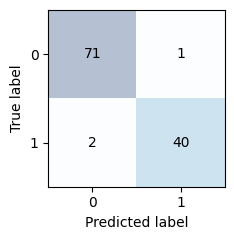

In [38]:
# 계산된 오차행렬을 그래프로
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('figures/06_09.png', dpi=300)
plt.show()

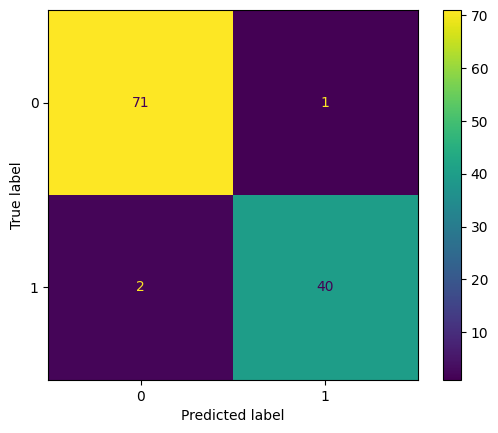

In [39]:
# ConfusionMatrixDisplay 클래스로 그린 오차 행렬
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)
plt.show()

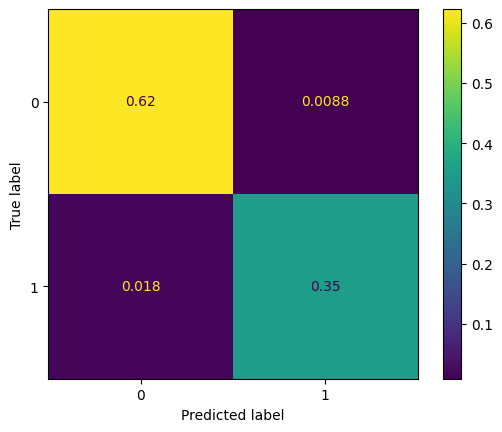

In [40]:
# normalize 매개변수를 사용하여 오차 행렬의 값을 정규화( 'true', 'pred'는 각각 행과 열 방향으로 정규화. 'all'로 지정하면 전체 출력 값을 정규화)
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test,
                                      normalize='all')
plt.show()

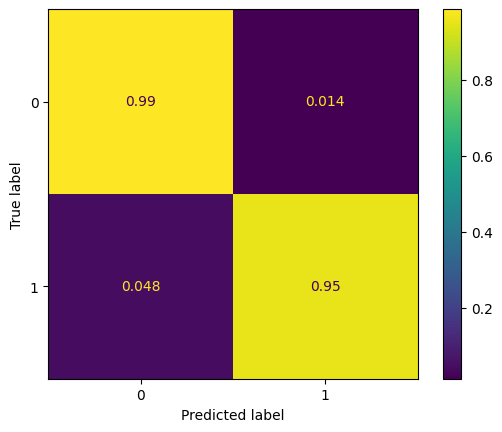

In [41]:
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test,
                                      normalize='true')
plt.show()

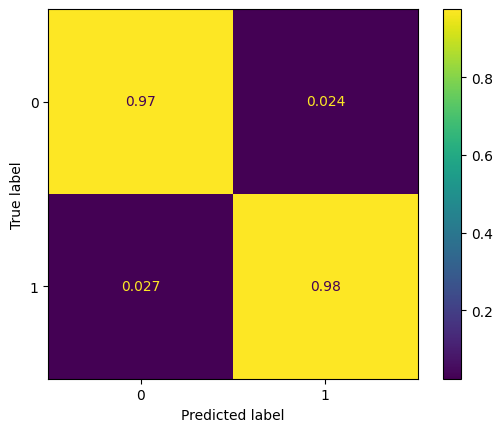

In [42]:
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test,
                                      normalize='pred')
plt.show()

### 분류 모델의 정밀도와 재현율 최적화

예측 오차(ERR)와 정확도(ACC) 모두 얼마나 많은 샘플을 잘못 분류했는지 일반적인 정보

예측 오차 잘못된 예측의 합을 전체 예측 샘플 개수로 나눈 것 (FP+FN)/(FP+FN+TP+TN)

정확도는 옳은 예측의 합을 전체 예측 샘플 개수로 나누어 계산 (TP+TN)/(FP+FN+TP+TN) = 1 - ERR

거짓 양성 비율(False Positive Rate, FPR)과 진짜 양성 비율(True Positive Rate, TPR)은 클래스 비율이 다른 경우 유용한 성능 지표
 - FPR = FP / N = FP / (FP + TN)
 - TPR = TP / P = TP / (FN + TP)

정밀도(PRE)와 재현율(REC) 성능 지표는 진짜 양성과 진짜 음성 샘플의 비율과 관련

재현율은 관련된 샘플(양성)을 얼마나 많이 (진짜 양성으로) 감지했는지 정량화
 - REC는 TPR의 다른 이름 REC = TPR = TP / P = TP / (FN + TP)

정밀도는 예측된 샘플(진짜 양성과 거짓 양성의 합) 중 실제로 관련된 샘플(진짜 양성)의 수를 정량화
 - PRE = TP / (TP + FP)

재현율과 정밀도는 앞서 1종 오류와 2종 오류에서 설명한 "α와 β는 서로 트레이드 오프 관계" 와 마찬가지로 트레이드오프 관계

재현율을 최적화 하면 실제 옳은 것을 찾지 못할 확률을 최소화 하지만, 옳지 않은데 옳다고 예측을 하는 비용이 발생
 - REC =  TP / (FN + TP) 로 인하여 FN을 줄이기 위해서는 FP가 높아진다.(긍정으로 예측하는 경우가 늘어남)

정밀도를 최적화 하면 얼마나 정확하게 예측하는 확률을 늘리지만, 실제 옳은 것을 놓치는 경우가 발생
 - PRE = TP / (TP + FP) 로 인하여 FP를 줄이기 위해서는 FN이 높아진다.(부정으로 예측하는 경우가 늘어남)

PRE와 REC 최적화로 인한 장단점의 균형을 맞추기 위해 PRE와 REC 조화 평균인 F1-점수를 자주 사용

F1= 2 * (PRE * REC)/(PRE + REC)

In [43]:
# 사이킷런에서 성능지표 구현
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'정밀도: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'재현율: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

정밀도: 0.976
재현율: 0.952
F1: 0.964
MCC: 0.943


In [44]:
# 사이킷런에서 양성 클래스는 레이블이 1, 양성 레이블을 바꾸려면  make_scorer 함수를 사용
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### ROC 곡선 그리기

ROC(Receiver Operating Characteristic) 그래프는 분류기의 임계 값을 바꾸어 가며 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택하는 유용한 도구

ROC 곡선의 아래 면적인 ROC AUC(ROC Area Under the Curve)를 계산하여 분류 모델의 성능을 종합

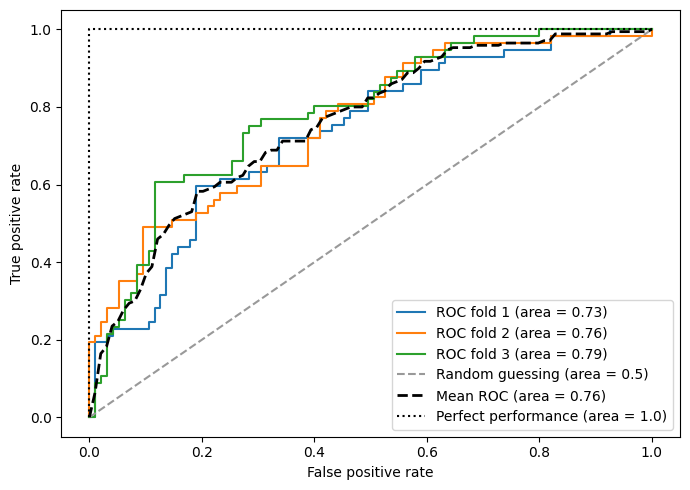

In [45]:
# 위스콘신 유방암 데이터셋에서 두 개의 특성을 추출하여 종양의 악성 여부를 예측하는 분류 모델의 ROC 곡선
from sklearn.metrics import roc_curve, auc
from numpy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2',
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]


cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area = 0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area = 1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
# plt.savefig('figures/06_10.png', dpi=300)
plt.show()

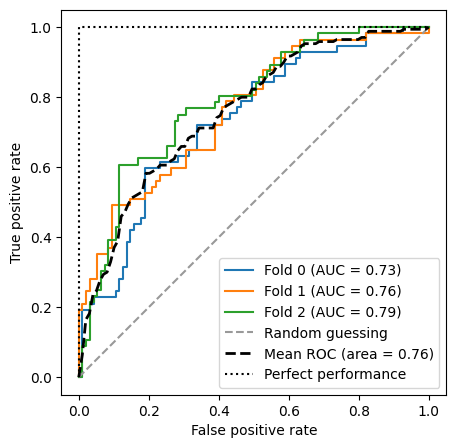

In [46]:
#  RocCurveDisplay 클래스로 구현한 ROC 곡선
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = RocCurveDisplay.from_estimator(pipe_lr,
                                              X_train2[test], y_train[test],
                                              name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

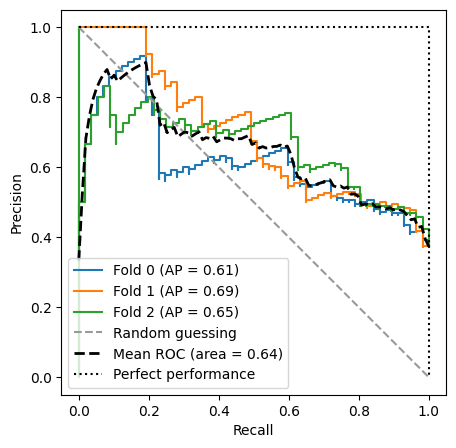

In [47]:
# PrecisionRecallDisplay 클래스로 구현한 정밀도 - 재현율 곡선
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = PrecisionRecallDisplay.from_estimator(
        pipe_lr, X_train2[test], y_train[test],
        name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1],
                             pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

### 다중 분류의 성능 지표

앞선 성능지표는 이진 분류에 대한 것으로, 이러한 평균 지표에 마크로와 마이크로 평균 방식을 구현하여 OvA(One-versus-All) 방식을 사용하는 다중 분류로 확장

마이크로 평균은 클래스별로 TP, TN, FP, FN을 계산, k개의 클래스가 있는 경우

정밀도의 마이크로 평균

PRE(micro) = (TP1 + TP2 + ... + TPk) / (TP1 + ... + TPk + FP1 + ... + FPk)

마크로 평균은 단순하게 클래스별 정밀도의 평균

PRE(macro) = (PRE1 + PRE2 + ... + PREk) / k

마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용합니다. 마크로 평균은 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가

사이킷런에서 이진 성능 지표로 다중 분류 모델을 평가하면 정규화 또는 가중치가 적용된 마크로 평균이 기본으로 적용

가중치가 적용된 마크로 평균은 레이블마다 샘플 개수가 다른 불균형한 클래스를 다룰 때 유용



In [48]:
# average 매개변수로 평균 계산
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

### 불균형한 클래스 다루기

In [49]:
# 위스콘신 유방암 데이터셋에서 212개의 악성 종양(클래스 1)과 357개의 양성 종양(클래스 0)을 가진 불균형한 데이터셋 생성
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [50]:
# 불균형 데이터셋으로 다수 클래스(양성 종양의 클래스 0)를 예측하는 모델의 정확도는 90%
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

np.float64(89.92443324937027)

In [51]:
'''
알고리즘이 훈련 과정에서 비용을 최소화하거나 보상을 최대화하기 위해 데이터셋에서 가장 빈도가 높은 클래스의 예측을 최적화하는 모델을 학습
모델을 훈련하는 동안 불균형한 클래스를 다루는 한 가지 방법은 소수 클래스에서 발생한 예측 오류에 큰 벌칙을 부여
다른 전략은 소수 클래스의 샘플을 늘리거나 다수 클래스의 샘플을 줄이거나 인공적으로 훈련 샘플을 생성
'''
# 불균형한 위스콘신 유방암 데이터셋에서 소수 클래스(여기에서는 클래스 1)를 선택하여 클래스 0인 샘플 개수와 동일할 때까지 새로운 샘플을 반복적으로 추출
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링하기 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링하기 후 클래스 1의 샘플 개수: 357


In [52]:
# 샘플을 추출한 후 클래스 0인 원본 샘플과 업샘플링(upsampling)된 클래스 1을 연결하여 균형 잡힌 데이터셋 생성
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [53]:
# 50% 정확도를 가짐
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

np.float64(50.0)

In [55]:
'''
다수 클래스의 훈련 샘플을 삭제하여 다운샘플링(downsampling)
클래스 레이블 1과 0을 서로 바꿈
'''
from sklearn.utils import resample

print('샘플링하기 전 클래스 0의 샘플 개수:', X_imb[y_imb == 0].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 0],
                                    y_imb[y_imb == 0],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 1].shape[0],
                                    random_state=123)

print('샘플링하기 후 클래스 0의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 0의 샘플 개수: 357
샘플링하기 후 클래스 0의 샘플 개수: 40
